In [9]:
import json
import os
import statistics
from typing import List, Tuple

import seaborn as sns

In [10]:
%matplotlib inline

In [11]:
def read_multi_json_objects_file(filename: str) -> List[dict]:
    with open(filename, 'r') as file:
        return [json.loads(line) for line in file]


# User History Analysis
## Visualizing the Validation Dataset

First, we import the unbatched raw data of userId -> {acrticleId}

In [12]:
path_to_json = '../data/user_articleid'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

user_article_map = {}

for json_file in json_files:
    user_histories = read_multi_json_objects_file(path_to_json + "/" + json_file)
    for user_with_history in user_histories:
        user_article_map[str(user_with_history["_1"])] = user_with_history["_2"]

user_histories = [a for a in user_article_map.values()]

Analysing out data, we find that the bulk of our users have only been tracked across 17 articles read

32.50584124904466
22.0


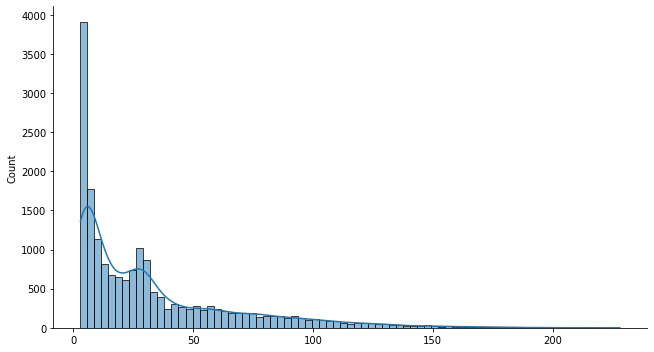

In [13]:
history_lengths = [len(history) for history in user_histories]

sns.displot(history_lengths, kde=True, aspect=20.7/11.27)

print(statistics.mean(history_lengths))
print(statistics.median(history_lengths))

Next, we want to observe how many unique histories have been observed

In [14]:
unique_histories_intermediate = set(tuple(i) for i in user_histories)
unique_histories = [list(i) for i in unique_histories_intermediate]

In [15]:
print("{0} of {1} are unique".format(len(unique_histories), len(user_histories)))
print(len(unique_histories) / len(user_histories))

18303 of 18318 are unique
0.9991811333114969


Only 6,5% of our encountered histories are duplicates. When removing duplicates we can observe the following shift

32.524613451346774
22


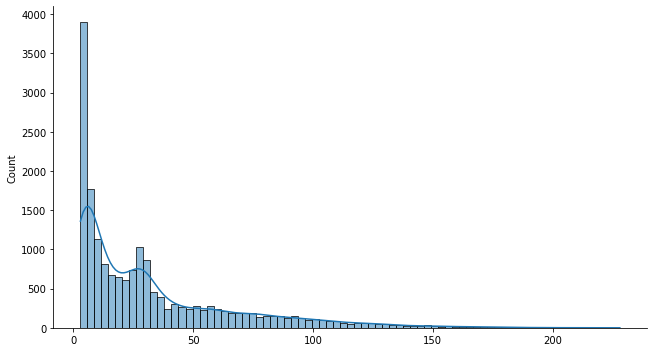

In [16]:
unique_history_lengths = [len(history) for history in unique_histories]

sns.displot(unique_history_lengths, kde=True, aspect=20.7/11.27)

print(statistics.mean(unique_history_lengths))
print(statistics.median(unique_history_lengths))

# Analysing resolved bert vectors

Since after being resolved, the characteristics of our data did potentially change, it is wise to
do some investigation on the qualities of the data our model has to learn and infer from.


Thus, our analysis here will be two-fold:
First we're analysing sequence level data, which is important for positional encoding and how much
having to learn padding is going to influence the model.

Second, we will analyze the data on a channel basis – this will show us if any channel-based alterations
have to be made to the data.

ACHTUNG: All analysis is done on the validation set.

In [17]:
# reads spark files and puts them into lines
def read_multi_json_objects_file(filename: str) -> List[dict]:
    with open(filename, 'r') as file:
        return [json.loads(line) for line in file]

# splits lines into user -> (history+target)
def extract_raw_history_data_from(data):
    return [history["value"] for history in data ]

In [25]:
train_test_data = read_multi_json_objects_file('../data/seq_16/val/1700.json')

## Sequence-level analysis

In [26]:
padding = [0.0] * 768
histories = extract_raw_history_data_from(train_test_data)

12.534297963558414
16.0


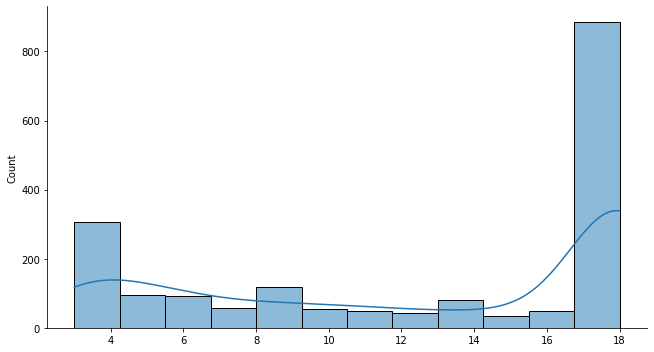

In [27]:
def with_padding_removed(single_history: List[List[float]]) -> List[List[float]]:
    return [article for article in single_history if article != padding]

unpadded_histories = list(map(with_padding_removed, histories))
train_history_lengths = [len(history) for history in unpadded_histories]

sns.displot(train_history_lengths, kde=True, aspect=20.7/11.27)

print(statistics.mean(train_history_lengths))
print(statistics.median(train_history_lengths))

Sequence-level mean as prediction

## Channel-level analysis

While the bulk of the indivdual channels accummulates around 0,
the sum of all channels for a single article appears to accummulate around -51.



Channel data ranges from -29.55918 to 3.40069


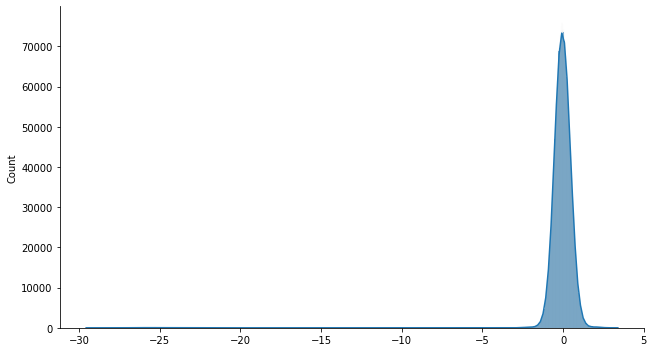

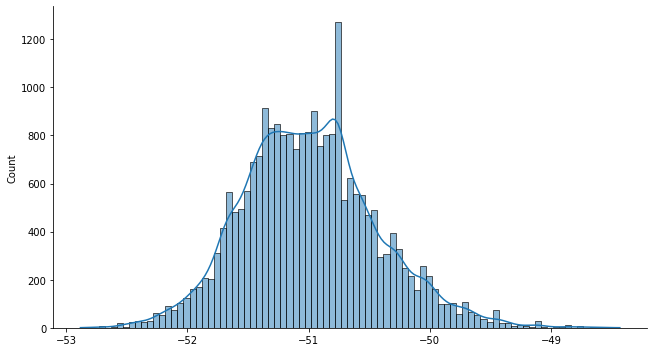

In [28]:
articles = [article for history in unpadded_histories for article in history]
channels = [channel for article in articles for channel in article]

min_channel = min(channels)
max_channel = max(channels)

print("Channel data ranges from {:5.5f} to {:5.5f}".format(min_channel, max_channel))

vector_sums = [sum(a) for a in articles]
sns.displot(channels, kde=True, aspect=20.7/11.27)
sns.displot(vector_sums, kde=True, aspect=20.7/11.27)

Analyse normalized data spreads

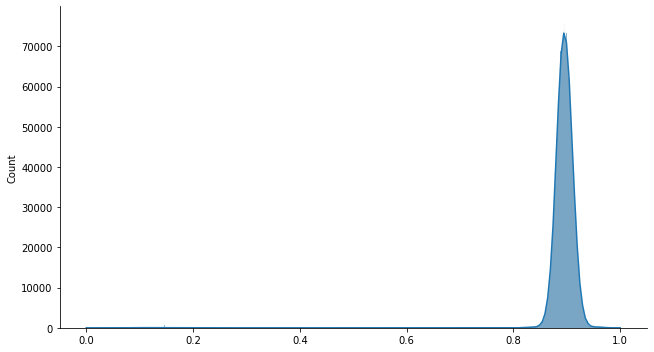

In [29]:
def normalize(channel: float) -> float:
    return (channel - min_channel)/(max_channel - min_channel)

normalized = list(map(normalize, channels))
sns.displot(normalized, kde=True, aspect=20.7/11.27)

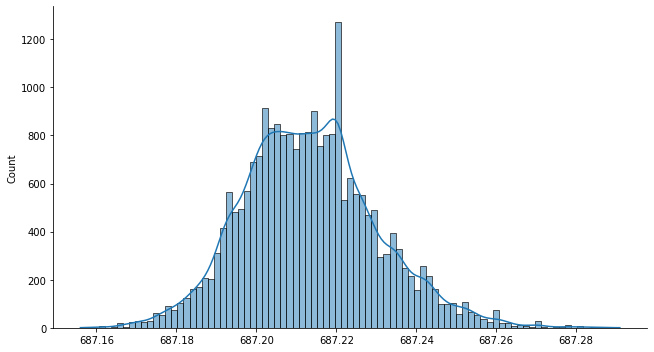

In [30]:
normalized_articles = [map(normalize, article) for article in articles]

normalized_sums = [sum(a) for a in normalized_articles]
sns.displot(normalized_sums, kde=True, aspect=20.7/11.27)